In [2]:
import tensorflow as tf
from tensorflow import keras
from sklearn import metrics
import pickle
from tensorflow import keras
from keras.regularizers import l2
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, TimeDistributed
from keras.layers import Embedding
from keras.layers import Conv1D, Conv2D, GlobalAveragePooling1D, MaxPooling1D, Bidirectional, LSTM, MaxPooling2D, MaxPooling3D, AveragePooling2D
from keras.regularizers import l2
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as MSE

In [8]:
def load_spots(chromosome):
    with open("data/"+chromosome+"_hotspot_data.pickle", "rb") as fp:
         hotspot_data = pickle.load(fp)
    with open("data/"+chromosome+"_coldspot_data.pickle", "rb") as fp:
         coldspot_data = pickle.load(fp)
    return hotspot_data, coldspot_data

def create_dataset(hotspots, coldspots, only_seq=False, flatten=False):
    X, y = [], []
    for row in hotspots:
        if only_seq: row = row[:, :4]
        #if only_seq: row = np.concatenate((row[:, :4], row[:, [5]]),axis=1)
        if flatten: row = row.flatten()
        X.append(row)
        y.append(1)
    
    for row in coldspots:
        if only_seq: row = row[:, :4]
        #if only_seq: row = np.concatenate((row[:, :4], row[:, [5]]),axis=1)
        if flatten: row = row.flatten()
        X.append(row)
        y.append(0)
    
    return X, y

In [6]:
def get_data(chromosomes):
    hotspots, coldspots = [], []
    for chromosome in chromosomes:
        hotspot, coldspot = load_spots(chromosome)
        hotspots+=hotspot
        coldspots+=coldspot
    return hotspots, coldspots

In [85]:
train_chromosomes = ['chr{}'.format(i) for i in range(1, 11, 2)]
train_hotspot, train_coldspot = get_data(train_chromosomes)

test_chromosomes = ['chr{}'.format(i) for i in range(11, 12)]
test_hotspot, test_coldspot = get_data(test_chromosomes)

In [84]:
data, labels = [], []
# for i in range(17, 18):
#     hotspots, coldspots = load_spots('chr'+str(i))
X, y = create_dataset(train_hotspot, train_coldspot, only_seq = False, flatten=False)
data += X
labels += y
    

In [48]:
print(len(y_train))

36701


In [65]:
#data = np.array(data).reshape(296576000, 1000, 8, 1)
data = np.asarray(data)
labels = np.array(labels)
print(data.shape)
print(labels.shape)

(37072, 8000)
(37072,)


In [66]:
#, kernel_regularizer=l2(0.001)
model = Sequential()

model.add(Conv1D(50, 25, activation='relu', input_shape=(1000,4)))
model.add(MaxPooling1D(3))
model.add(Conv1D(50, 25,activation='relu'))
model.add(MaxPooling1D(3))
model.add(Bidirectional(LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.1)))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

#model.add(Dense(1, activation='sigmoid', input_shape = (8000,))) # <--for the simple NN
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1)                 8001      
Total params: 8,001
Trainable params: 8,001
Non-trainable params: 0
_________________________________________________________________


In [67]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size = 0.99, test_size=0.01, random_state = 0)

print(y_train[0:10])

[1 0 1 0 1 0 0 0 1 1]


In [68]:

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_acc', patience=1)
]

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_split=0.2, batch_size=100, epochs=15)

Train on 29360 samples, validate on 7341 samples
Epoch 1/15
29360/29360 [==============================] - 8s 272us/step - loss: 0.5847 - acc: 0.6953 - val_loss: 0.6150 - val_acc: 0.6799
Epoch 2/15
29360/29360 [==============================] - 2s 65us/step - loss: 0.5394 - acc: 0.7347 - val_loss: 0.5970 - val_acc: 0.6889
Epoch 3/15
29360/29360 [==============================] - 2s 65us/step - loss: 0.5231 - acc: 0.7456 - val_loss: 0.6136 - val_acc: 0.6883
Epoch 4/15
29360/29360 [==============================] - 2s 65us/step - loss: 0.5194 - acc: 0.7491 - val_loss: 0.6207 - val_acc: 0.6830
Epoch 5/15
29360/29360 [==============================] - 2s 65us/step - loss: 0.5103 - acc: 0.7520 - val_loss: 0.6446 - val_acc: 0.6846
Epoch 6/15
29360/29360 [==============================] - 2s 65us/step - loss: 0.5066 - acc: 0.7559 - val_loss: 0.6623 - val_acc: 0.6740
Epoch 7/15
29360/29360 [==============================] - 2s 65us/step - loss: 0.5053 - acc: 0.7553 - val_loss: 0.6934 - val_acc

In [1]:
from keras.models import load_model

#model.save('CRNN_4param.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('CRNN.h5')

Using TensorFlow backend.


In [89]:
chromosome='chr11'
with open("data/"+chromosome+"_hotspot_data.pickle", "rb") as fp:
    midspot_data = pickle.load(fp)

In [3]:
plt.rcParams['figure.figsize']=(35,10)
plt.plot(history.history['acc'],color='k',linestyle=(0,(5,10)))
plt.plot(history.history['val_acc'],color='k')
plt.title('model accuracy',fontsize=30)
plt.yticks(fontsize=26)
plt.xticks(fontsize=26)
plt.ylabel('accuracy',fontsize=30)
plt.xlabel('epoch',fontsize=30)
plt.legend(['train', 'val'], loc='lower right',prop={'size': 30})
plt.show()

plt.plot(history.history['loss'],color='k',linestyle=(0,(5,10)))
plt.plot(history.history['val_loss'],color='k')
plt.title('model loss',fontsize=30)
plt.yticks(fontsize=26)
plt.xticks(fontsize=26)
plt.ylabel('loss',fontsize=30)
plt.xlabel('epoch',fontsize=30)
plt.legend(['train', 'val'], loc='upper right',prop={'size': 30})
plt.show()

NameError: name 'history' is not defined

In [87]:
#create testing set from chr11
data, labels = [], []
# for i in range(17, 18):
#     hotspots, coldspots = load_spots('chr'+str(i))
X, y = create_dataset(test_hotspot, test_coldspot, only_seq = False, flatten=False)
data += X
labels += y
x_test = np.asarray(data)
y_test = np.asarray(labels)

In [88]:
score = model.evaluate(x_test, y_test, batch_size=100)
print(model.metrics_names)
print(score)

6487/6487 [==============================] - 15s 2ms/step
['loss', 'acc']
[0.5521755105397615, 0.7226761236054073]


In [90]:
midspot_data = np.asarray(midspot_data)

In [79]:
ypred = model.predict(midspot_data)

In [80]:
with open("slidepredicts11Mid.txt", "wb") as fp: 
    pickle.dump(ypred, fp)

In [425]:
#sort predictions according to labels
zp = []
op = []
zt = []
ot = []
ypred = ypred.flatten()
for i in range(len(ypred)):
    if(y_test[i]==0):
        zt.append(0)
        zp.append(ypred[i])
    else:
        ot.append(1)
        op.append(ypred[i])
op = op + zp
ot = ot + zt

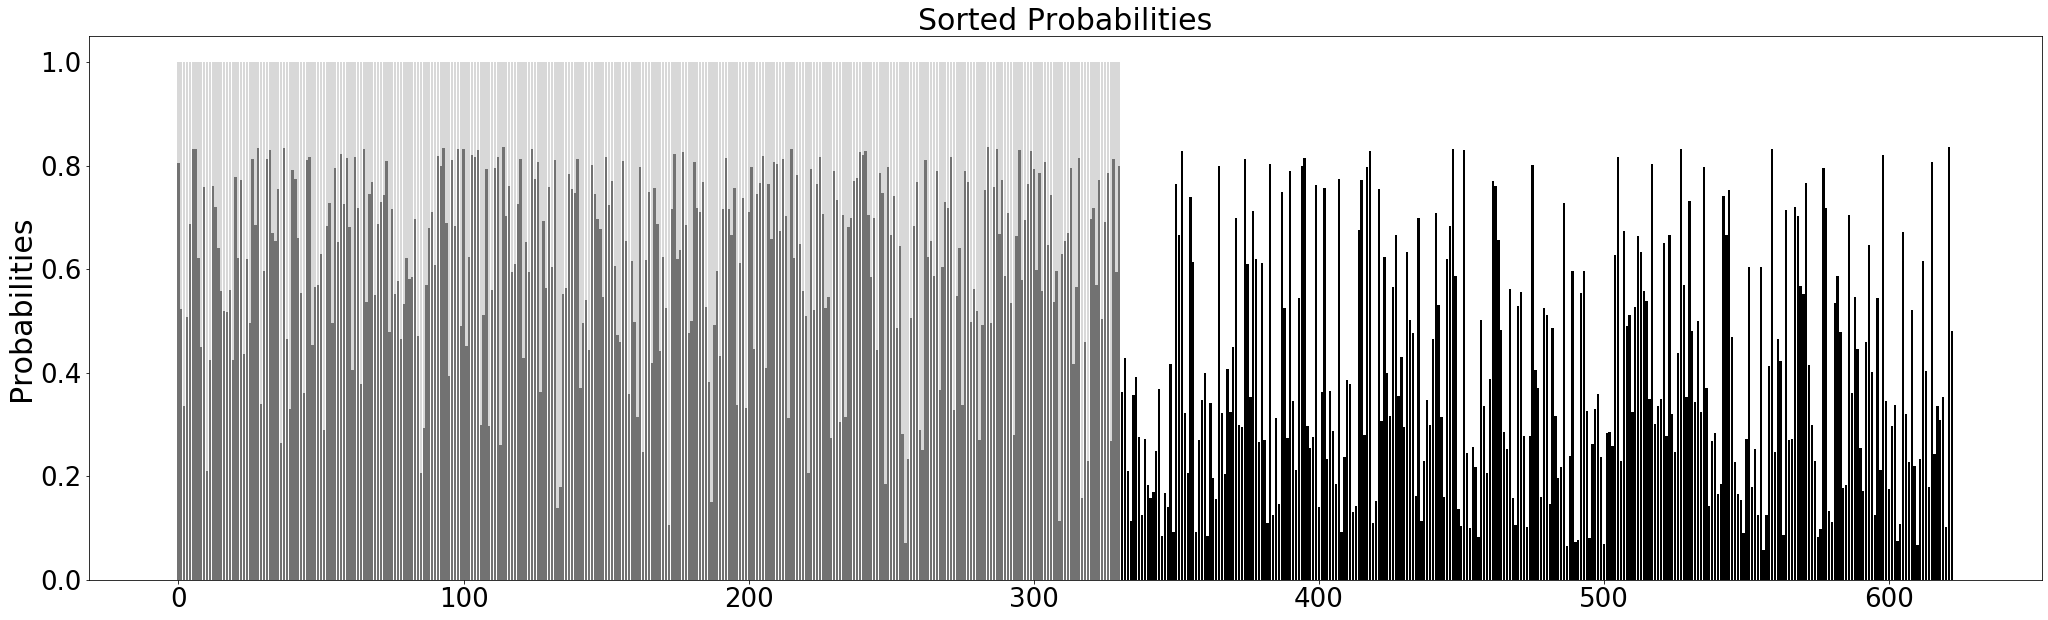

In [426]:
#plot sorted
xrange = [i for i in range(len(ypred))]
plt.rcParams['figure.figsize']=(35,10) 
plt.title('Sorted Probabilities',fontsize=30)
plt.ylabel('Probabilities',fontsize=30)
plt.yticks(fontsize=26)
plt.xticks(fontsize=26)
plt.bar(xrange, op, color = 'k')
plt.bar(xrange, ot, color = '0.75',alpha = 0.6)
plt.show()



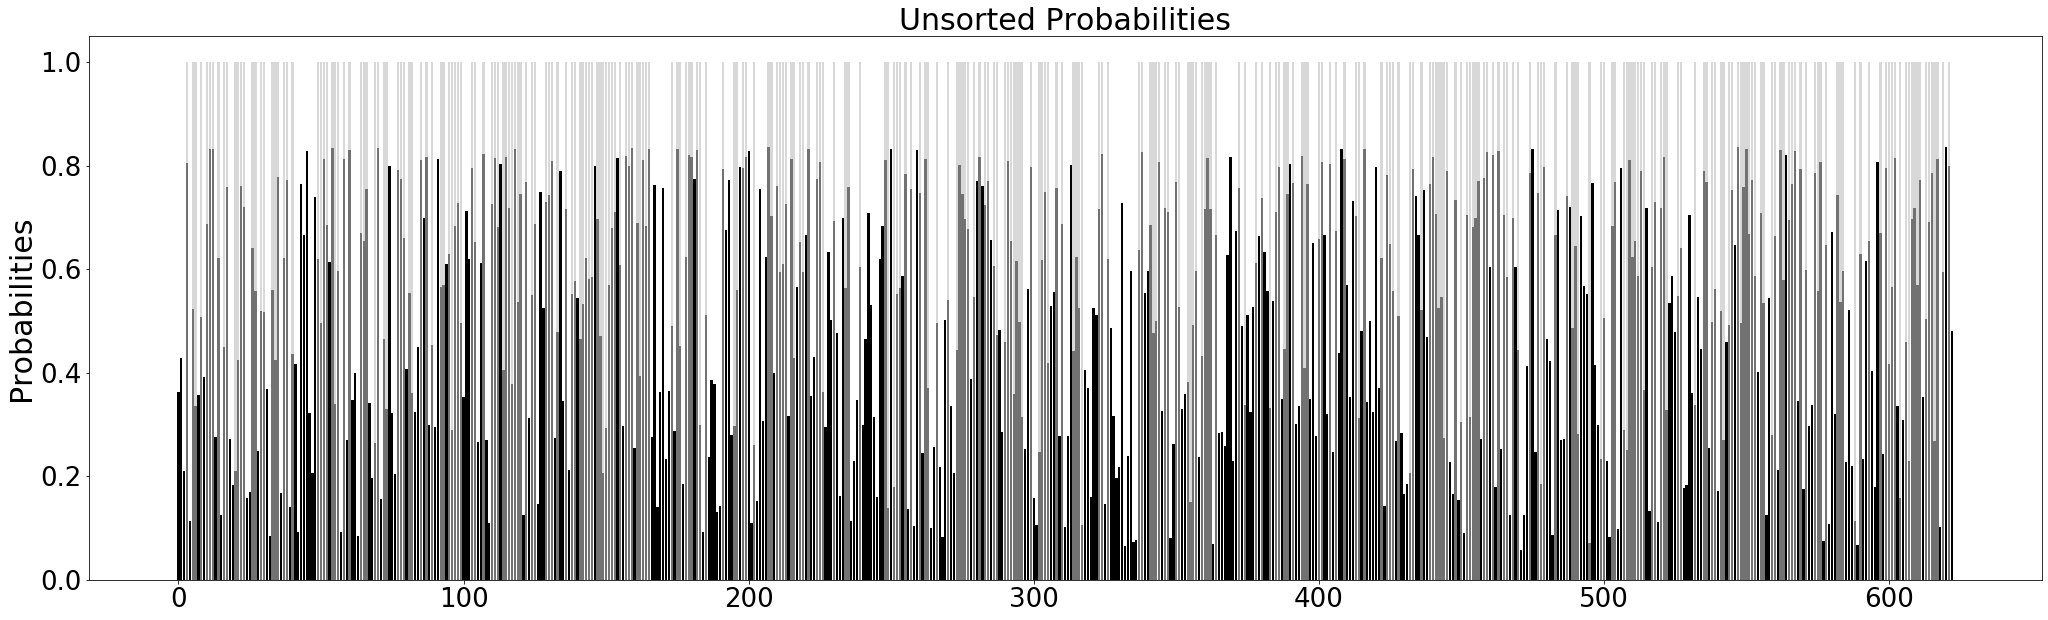

In [427]:
#plot unsorted
plt.rcParams['figure.figsize']=(35,10)   
plt.title('Unsorted Probabilities',fontsize=30)
plt.ylabel('Probabilities',fontsize=30)
plt.bar(xrange, ypred, color = 'k')
plt.yticks(fontsize=26)
plt.xticks(fontsize=26)
plt.bar(xrange, y_test, color = '0.75',alpha = 0.6)
plt.show()

In [304]:
slidedata, slidelabels = [], []
for i in range(1, 2):
    hotspots, coldspots = load_spots('chr'+str(i))
    X, y = create_dataset(hotspots, coldspots, only_seq = False, flatten=False)
    slidedata += X
    slidelabels += y
    

In [305]:
data = np.asarray(data)
labels = np.array(labels)
print(data.shape)
print(labels.shape)

(3300, 1000, 8)
(3300,)


In [306]:
print(labels)

[1 1 1 ... 0 0 0]
